In [1]:
from brian2 import *
prefs.codegen.target = 'numpy'  # switches off code generation (examples are too simply to benefit)

All examples (slighty adapted) from https://brian2.readthedocs.io

## f/I curve of an LIF model (Examples: `IF_curve_LIF.py`)

In [2]:
start_scope()  # only necessary when running multiple examples in the same session, e.g. notebook

duration = 1*second
N_neurons = 100
C = 200*pF
g_L = 10*nS
tau = C/g_L
V_rest = -70*mV
V_threshold = -50*mV
V_reset = V_rest

eqs = '''
dV/dt = (I_stim +  g_L*(V_rest - V)) / C: volt (unless refractory)
I_stim : amp (constant)
'''
group = NeuronGroup(N_neurons, eqs, threshold='V > V_threshold', reset='V = V_reset',
                    refractory=5*ms, method='euler')
group.V = 0*mV
group.I_stim = '1*nA * i / (N_neurons-1)'

monitor = SpikeMonitor(group)
v_monitor = StateMonitor(group, 'V', record=True)

run(duration)

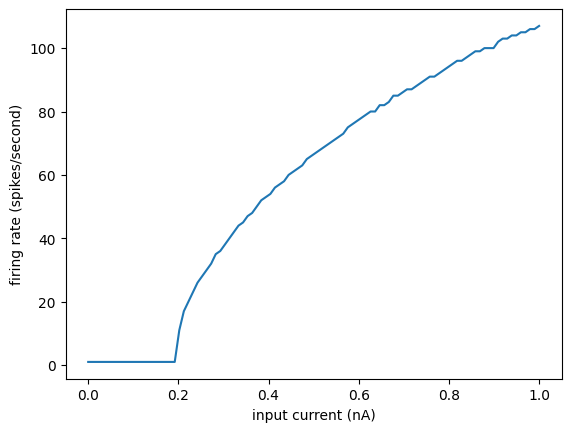

In [3]:
fig, ax = plt.subplots()
ax.plot(group.I_stim/nA, monitor.count/duration)
ax.set(xlabel='input current (nA)', ylabel='firing rate (spikes/second)');

---


## Randomly connected network with exponential, current-based synapses
### Examples: `CUBA.py`

In [4]:
start_scope()

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -65*mV
I_ext = 16*mV

eqs = '''
dv/dt  = ((El - v) + I_e + I_i + I_ext)/taum : volt (unless refractory)
dI_e/dt = -I_e/taue : volt
dI_i/dt = -I_i/taui : volt
'''

P = NeuronGroup(4000, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')
P.v = 'Vr + rand() * (Vt - Vr)'

we = 1.62*mV  # excitatory weight
wi = -9*mV    # inhibitory weight
Ce = Synapses(P[:3200], P, on_pre='I_e += we')
Ci = Synapses(P[3200:], P, on_pre='I_i += wi')
Ce.connect(p=0.02)
Ci.connect(p=0.02)

s_mon = SpikeMonitor(P)
state_mon = StateMonitor(P, ['v', 'I_e', 'I_i'], record=0)
run(1 * second, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 1s


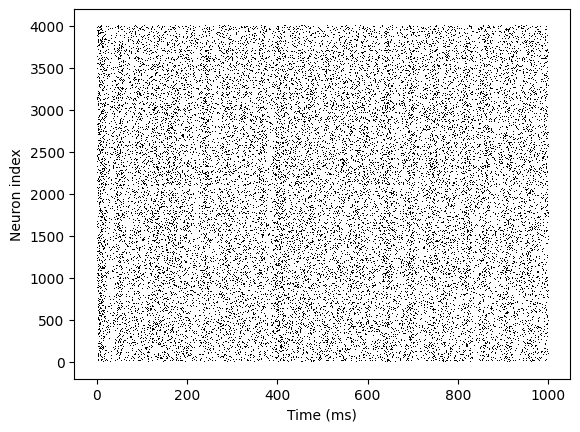

In [5]:
plt.plot(s_mon.t/ms, s_mon.i, ',k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index');

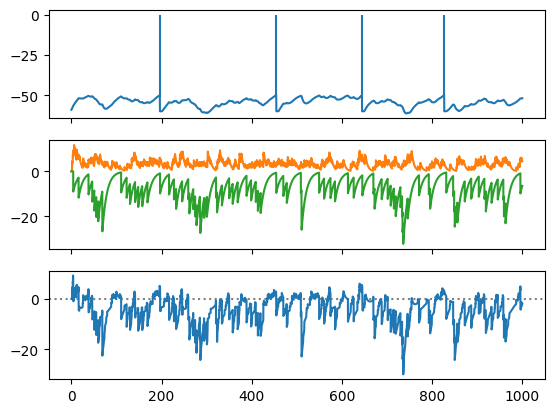

In [6]:
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(state_mon.t/ms, state_mon.v[0]/mV)
axs[0].vlines(s_mon.spike_trains()[0]/ms, Vt/mV, 0)
axs[0].set_ylabel("v (mV)")

axs[1].plot(state_mon.t/ms, state_mon.I_e[0]/mV, color='C1', label="$I_e$")
axs[1].plot(state_mon.t/ms, state_mon.I_i[0]/mV, color='C2', label="$I_i$")
axs[1].set_ylabel("$I$ (mV)")
axs[1].legend()
axs[2].axhline(0, color='gray', ls=':')
axs[2].plot(state_mon.t/ms, state_mon.I_e[0]/mV + state_mon.I_i[0]/mV, color='C0');

---

## Spike-timing dependent plasticity
### Examples: synapses → `STDP.py`

In [7]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input_spikes = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input_spikes, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input_spikes)

run(50*second, report='text')

Starting simulation at t=0. s for a duration of 50. s
8.5228 s (17%) simulated in 10s, estimated 49s remaining.
17.07 s (34%) simulated in 20s, estimated 39s remaining.
25.7353 s (51%) simulated in 30s, estimated 28s remaining.
34.4297 s (68%) simulated in 40s, estimated 18s remaining.
43.1363 s (86%) simulated in 50s, estimated 8s remaining.
50. s (100%) simulated in 57s


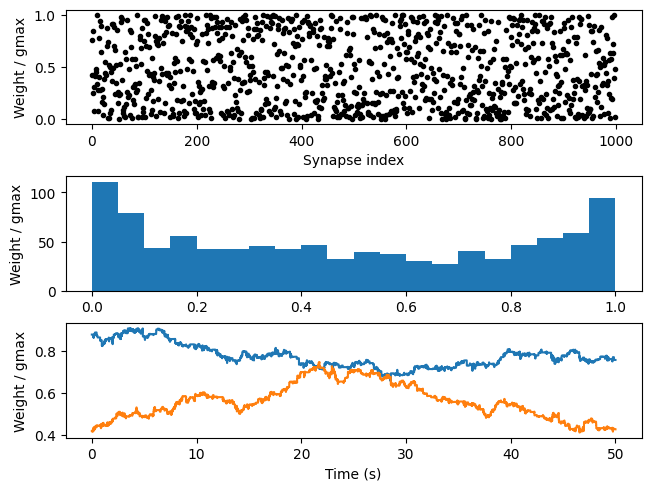

In [8]:
fig, axs = plt.subplots(3, 1, layout='constrained')
axs[0].plot(S.w / gmax, '.k')
axs[0].set(xlabel='Synapse index', ylabel='Weight / gmax')

axs[1].hist(S.w / gmax, 20)
axs[1].set(ylabel='Weight / gmax')

axs[2].plot(mon.t/second, mon.w.T/gmax)
axs[2].set(xlabel='Time (s)', ylabel='Weight / gmax');